In [157]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import xarray as xr
import geoviews as gv
import geoviews.feature as gf

In [158]:
#run the file containing the script to download OCADS data
%run read_data.py

In [366]:
#read in pH, Sea Surface Temperature, and CO2 data

pH_data = download_OCADS_data("pHT", "historical")
SST_data = download_OCADS_data("Temperature", "historical")
fCO2_data = download_OCADS_data("fCO2", "historical")

In [367]:
#convert data to xr Data Arrays

pH_global = pH_data['pHT']['historical']
SST_global = SST_data['Temperature']['historical']
fCO2_global = fCO2_data['fCO2']['historical']
pH_global

<xarray.DataArray 'pHT' (time: 18, lat: 180, lon: 360)> Size: 9MB
[1166400 values with dtype=float64]
Coordinates:
  * time     (time) float64 144B 1.75e+03 1.85e+03 1.86e+03 ... 2e+03 2.01e+03
Dimensions without coordinates: lat, lon
Attributes:
    long name:  pH on total hydrogen ion scale
    CF_name:    sea_water_ph_reported_on_total_scale
    units:      N/A

In [368]:
#convert lat from 0 - 180 to -90 - 90 and convert lon from 0 - 360 to -180 - 180

pH_global.coords['lon'] = ((pH_global.coords['lon'] + 180) % 360) - 160
pH_global.coords['lat'] = (pH_global.coords['lat'] - 90)
pH_global = pH_global.sortby(pH_global.lon)
pH_global.lon

<xarray.DataArray 'lon' (lon: 360)> Size: 3kB
array([-160, -159, -158, ...,  197,  198,  199], shape=(360,))
Coordinates:
  * lon      (lon) int64 3kB -160 -159 -158 -157 -156 ... 195 196 197 198 199

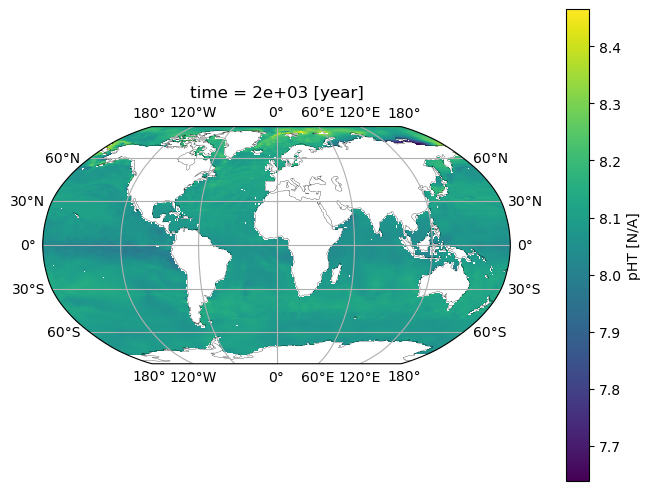

In [369]:
# create a figure
fig = plt.figure(constrained_layout=True)

# assign axis and define the projection -  centred in pacific
ax = plt.axes(projection = ccrs.Robinson())

# add coastlines
ax.coastlines(linewidth=0.2)

# add gridlines (lon and lat)
ax.gridlines(draw_labels=True)

"""
ax.add_patch(
    patches.Rectangle(
        xy=(min_f0, min_f1),  # point of origin.
        width=width, height=height, linewidth=1,
        color='red', fill=False))
"""

# example plot of pH in year 2000
pH_global.sel(time=2000).plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()

In [370]:
#Definte bounds for areas of interest
WA_lims = {'lat':(0, 27), 'lon':(-21, 27)}

In [371]:
pH_WA = pH_global.where((pH_global.lat > WA_lims['lat'][0]) & (pH_global.lat < WA_lims['lat'][1]) & (pH_global.lon > WA_lims['lon'][0]) & (pH_global.lon < WA_lims['lat'][1]))

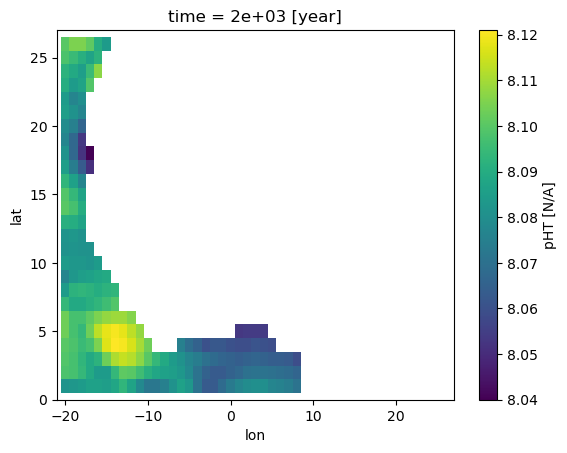

In [372]:
pH_WA.sel(time=2000).plot(xlim = WA_lims['lon'], ylim = WA_lims['lat'])

In [377]:
#Define climatology period (in this case 1850 - 1870). This dataset is only resolved decadally so there are only 3 data points
pH_30yr = pH_global.sel(time=slice(1850, 1870))
pH_clim = pH_30yr.mean(dim='time')
pH_clim

<xarray.DataArray 'pHT' (lat: 180, lon: 360)> Size: 518kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [8.257     , 8.25566667, 8.25166667, ..., 8.26133333, 8.26133333,
        8.26      ],
       [8.23433333, 8.22966667, 8.22333333, ..., 8.24266667, 8.243     ,
        8.24033333],
       [8.17966667, 8.17966667, 8.18      , ..., 8.18033333, 8.17966667,
        8.17966667]], shape=(180, 360))
Coordinates:
  * lat      (lat) int64 1kB -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89
  * lon      (lon) int64 3kB -160 -159 -158 -157 -156 ... 195 196 197 198 199

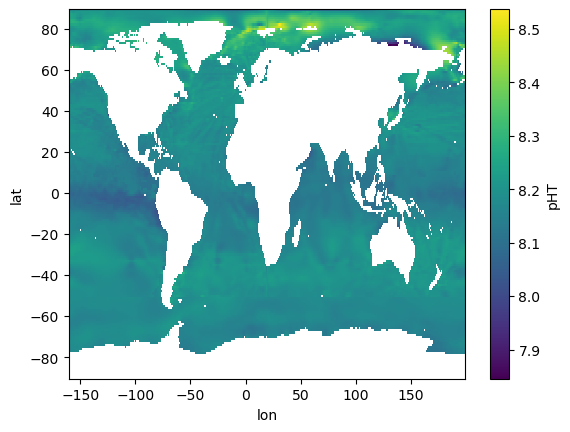

In [376]:
pH_clim.plot()

In [378]:
#Calculate anomaly using climatology
pH_anom = pH_global - pH_clim
pH_anom

<xarray.DataArray 'pHT' (time: 18, lat: 180, lon: 360)> Size: 9MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.01      ,  0.00933333,  0.00933333, ...,  0.01066667,
          0.01066667,  0.01      ],
        [ 0.01866667,  0.01833333,  0.01866667, ...,  0.01833333,
          0.019     ,  0.01866667],
        [ 0.00933333,  0.00933333,  0.01      , ...,  0.00866667,
          0.00933333,  0.00933333]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.07      , -0.06966667, -0.06766667, ..., -0.07433333,
         -0.07233333, -0.071     ],
        [-0.08533333, -0.08666667, -0.08833333, ..., -0.08466667,
         -0.084     , -0.08433333],
        [-0.09966667, -0.10066667, -0.101     , ..., -0.09833333,
         -0.09866667, -0.09966667]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.091     , -0.09066667, -0.08966667, ..., -0.09233333,
         -0.09033333, -0.09      ],
        [-0.10133333, -0.10266667, -0.10433333, ..., -0.09966667,
         -0.099     , -0.09933333],
        [-0.11366667, -0.11366667, -0.113     , ..., -0.11333333,
         -0.11266667, -0.11366667]]], shape=(18, 180, 360))
Coordinates:
  * time     (time) float64 144B 1.75e+03 1.85e+03 1.86e+03 ... 2e+03 2.01e+03
  * lat      (lat) int64 1kB -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89
  * lon      (lon) int64 3kB -160 -159 -158 -157 -156 ... 195 196 197 198 199

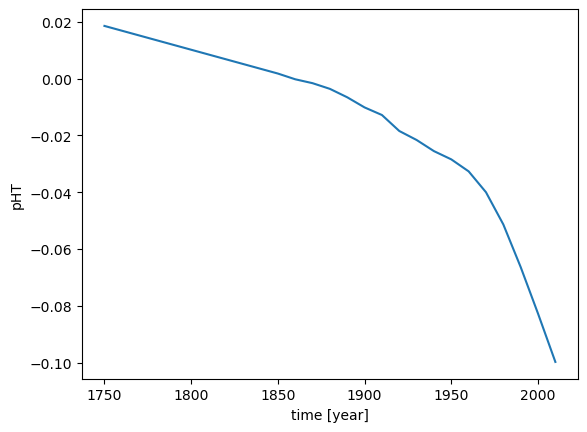

In [382]:
#Plot anomaly over time
pH_anom.mean(dim=['lat', 'lon']).plot()